## Import necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import hdf5plugin
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
from CellPLM.utils import set_seed
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import scanpy as sc
import matplotlib.pyplot as plt
import rapids_singlecell as rsc  # For faster evaluation, we recommend the installation of rapids_singlecell.

## Specify important parameters before getting started

In [2]:
PRETRAIN_VERSION = '20231027_85M'
DEVICE = 'cuda:0'
DATA_DIR = '/data/Mamba/Project/Single_Cell/Benchmark/CellPLM'

## Load Downstream Dataset

The example dataset here is from [GSE155468](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE155468).


In [3]:
set_seed(42)

data = ad.read_h5ad(f'{DATA_DIR}/data/gse155468.h5ad')
data.obs_names_make_unique()
data

2025-10-16 16:21:18 | [INFO] Setting global random seed to 42


AnnData object with n_obs × n_vars = 48082 × 12382
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'integrated_snn_res.0.6', 'seurat_clusters', 'celltype', 'celltype2'

## Set up the pipeline

In [4]:
pipeline = CellEmbeddingPipeline(
    pretrain_prefix=PRETRAIN_VERSION, 	# Specify the pretrain checkpoint to load
    pretrain_directory=f'{DATA_DIR}/ckpt'
)
pipeline.model

OmicsFormer(
  (embedder): OmicsEmbeddingLayer(
    (act): ReLU()
    (norm0): GroupNorm(4, 1024, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (extra_linear): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): GroupNorm(4, 1024, eps=1e-05, affine=True)
    )
    (pe_enc): Sinusoidal2dPE(
      (pe_enc): Embedding(10000, 1024)
    )
    (feat_enc): OmicsEmbedder()
  )
  (mask_model): MaskBuilder()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x FlowformerLayer(
        (self_attn): Flow_Attention(
          (query_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (key_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (value_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
         

## Evaluation and Inference

Once the pipeline is initialized, performing inference (cell embedding query) or evaluation on new datasets (with clustering metrics) can be easily accomplished using the built-in `predict` and `score` functions.

2025-10-16 16:21:30 | [WARNING] Input sequence provided is already in string format. No operation performed
2025-10-16 16:21:30 | [WARNING] Input sequence provided is already in string format. No operation performed
2025-10-16 16:21:30 | [INFO] querying 1-1000 ...


Automatically converting gene symbols to ensembl ids...


2025-10-16 16:21:33 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:34 | [INFO] querying 1001-2000 ...
2025-10-16 16:21:35 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:36 | [INFO] querying 2001-3000 ...
2025-10-16 16:21:38 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:39 | [INFO] querying 3001-4000 ...
2025-10-16 16:21:40 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:41 | [INFO] querying 4001-5000 ...
2025-10-16 16:21:42 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:43 | [INFO] querying 5001-6000 ...
2025-10-16 16:21:44 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21:45 | [INFO] querying 6001-7000 ...
2025-10-16 16:21:46 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:21

After filtering, 9955 genes remain.
[2025-10-16 16:22:23.889] [CUML] [info] build_algo set to brute_force_knn because random_state is given


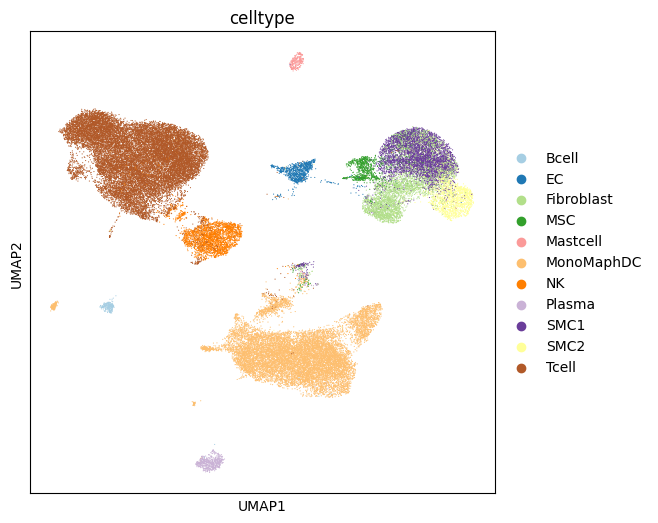

In [5]:
embedding = pipeline.predict(
    adata=data,
    device=DEVICE
)

data.obsm['emb'] = embedding.cpu().numpy()
sc.pp.neighbors(data, use_rep='emb', method='rapids') # remove method='rapids' if rapids is not installed
sc.tl.umap(data, method='rapids') # remove method='rapids' if rapids is not installed
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(data, color='celltype', palette='Paired')

In [6]:
pipeline.score(data,
               label_fields=['celltype'],
               evaluation_config = {
                   'method': 'rapids', # change to 'scanpy' if 'rapids_singlecell' is not installed; the final scores may vary due to the implementation
                   'batch_size': 50000, # Specify batch size to limit gpu memory usage
               },
               device=DEVICE) # Specify a gpu or cpu for model inference

2025-10-16 16:22:27 | [WARNING] Input sequence provided is already in string format. No operation performed
2025-10-16 16:22:27 | [WARNING] Input sequence provided is already in string format. No operation performed
2025-10-16 16:22:27 | [INFO] querying 1-1000 ...


Automatically converting gene symbols to ensembl ids...


2025-10-16 16:22:30 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:31 | [INFO] querying 1001-2000 ...
2025-10-16 16:22:33 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:34 | [INFO] querying 2001-3000 ...
2025-10-16 16:22:35 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:36 | [INFO] querying 3001-4000 ...
2025-10-16 16:22:37 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:38 | [INFO] querying 4001-5000 ...
2025-10-16 16:22:39 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:40 | [INFO] querying 5001-6000 ...
2025-10-16 16:22:42 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22:43 | [INFO] querying 6001-7000 ...
2025-10-16 16:22:44 | [INFO] HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-10-16 16:22

After filtering, 9955 genes remain.


{'ari': 0.8271826538238439, 'nmi': np.float64(0.8052624689872406)}